In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

# 1.1 Call sklearn libraries

# 1.1.1 Split data into train and test data
from sklearn.model_selection import train_test_split

# 1.1.2 PReprocessong:
from sklearn.preprocessing import StandardScaler

# 1.1.3 Import class DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier as dtree

# 1.1.4 To draw decision tree
from sklearn.tree import export_graphviz

# 1.1.7
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("C:\\Users\\Dell\\Downloads\\archive (1)\german_credit_data.csv")

In [3]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
df.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [5]:
df.shape

(1000, 11)

In [7]:
df.Housing.unique()

array(['own', 'free', 'rent'], dtype=object)

In [8]:
df.Purpose.unique()

array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], dtype=object)

Text(0.5, 1.0, 'Correlation Factors Heat Map')

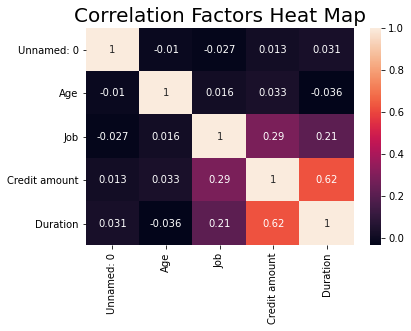

In [9]:
#to see the correaltion between the various variables
sns.heatmap(df.corr(), annot=True).set_title('Correlation Factors Heat Map', color='black', size='20')

In [10]:
df['Job'].value_counts()

2    630
1    200
3    148
0     22
Name: Job, dtype: int64

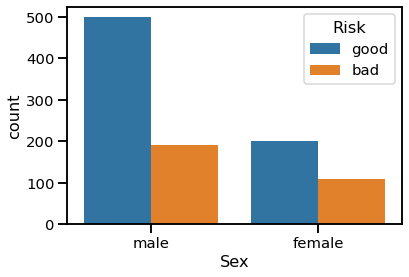

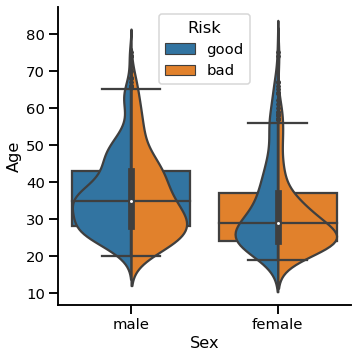

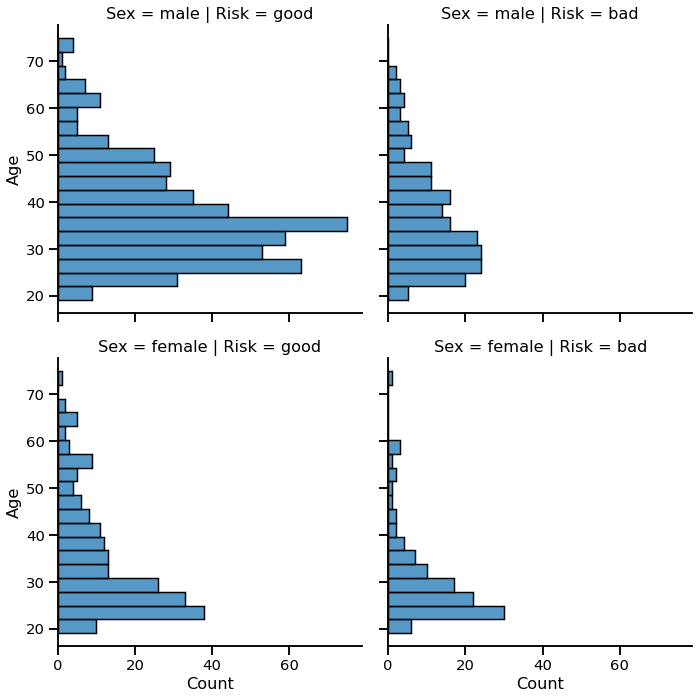

In [27]:
sns.set_context('talk', font_scale=.9)
# Example of types of analysis that can be done

# Count plot helps us visualize the number of elements per category
sns.countplot(data=df, x='Sex', hue='Risk')

# Box plot helps us see the mean value of a category "Sex" per "Age" in our dataset
sns.catplot(data=df, x='Sex', y='Age', kind='box')

# Split violin plots help us contrast the distribution across a hue value "Risk"
sns.violinplot(data=df, x='Sex', y='Age', hue='Risk', split=True)

# Displot help us visualize the distribution with histograms
sns.displot(data=df, row='Sex', y='Age', col='Risk')

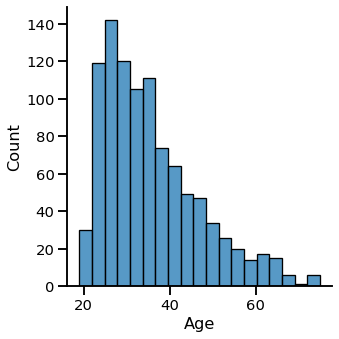

In [26]:
# Let's see how age is distributed
sns.displot(df['Age'])

#Let us split age into categories
interval = (18, 25, 35, 60, 120)
cats = ['Young Adult', 'Adult', 'Senior', 'Elder']
df["Age_cat"] = pd.cut(df['Age'], interval, labels=cats)

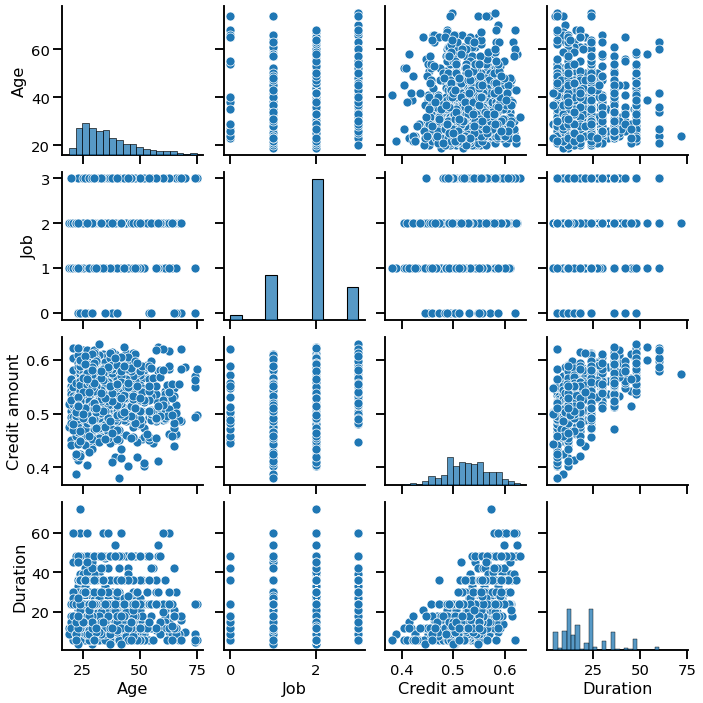

In [29]:
sns.pairplot(df);

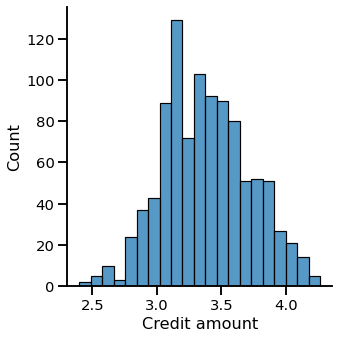

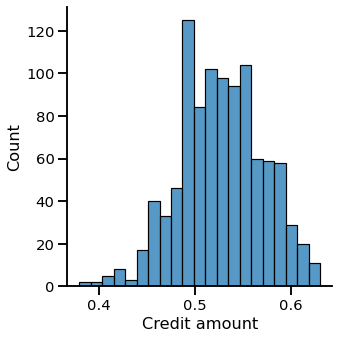

In [25]:
# Let's see how is credit amount distributed
sns.displot(df['Credit amount'])

# Another way to represent long tail numerical distributions is to transform them
# using e.g., a log function
sns.displot(np.log10(df['Credit amount']))

# Apply the new distribution to the dataset
df['Credit amount'] = np.log10(df['Credit amount'])

In [14]:
df['Saving accounts'] = df['Saving accounts'].fillna('no_inf')
df['Checking account'] = df['Checking account'].fillna('no_inf')

In [15]:
def one_hot_encoder(df, column_name, exclude_col = False):
    merged_df = df.merge(pd.get_dummies(df[column_name], drop_first=False, prefix=column_name), left_index=True, right_index=True)
    if exclude_col:
        del merged_df[column_name] # Exclude the original column
    return merged_df

In [16]:
df.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk',
       'Age_cat'],
      dtype='object')

In [17]:
df = df.drop('Unnamed: 0', axis='columns')
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,67,male,2,own,no_inf,little,3.067815,6,radio/TV,good,Elder
1,22,female,2,own,little,moderate,3.774590,48,radio/TV,bad,Young Adult
2,49,male,1,own,little,no_inf,3.321391,12,education,good,Senior
3,45,male,2,free,little,little,3.896636,42,furniture/equipment,good,Senior
4,53,male,2,free,little,little,3.687529,24,car,bad,Senior


In [18]:
df_ready = df.copy()


category_features = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk'] #'Age_cat']

# Note to DIEGO: Uncomment this line of code to include the age category
category_features = ['Job','Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk', 'Age_cat']

for cat in category_features:
    df_ready = one_hot_encoder(df_ready, cat, exclude_col=True)

In [19]:
df_ready.columns

Index(['Age', 'Credit amount', 'Duration', 'Job_0', 'Job_1', 'Job_2', 'Job_3',
       'Sex_female', 'Sex_male', 'Housing_free', 'Housing_own', 'Housing_rent',
       'Saving accounts_little', 'Saving accounts_moderate',
       'Saving accounts_no_inf', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_little',
       'Checking account_moderate', 'Checking account_no_inf',
       'Checking account_rich', 'Purpose_business', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Risk_bad', 'Risk_good',
       'Age_cat_Young Adult', 'Age_cat_Adult', 'Age_cat_Senior',
       'Age_cat_Elder'],
      dtype='object')

### Decision Tree Classifier

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dataset_ready_x = df_ready.drop(['Risk_bad', 'Risk_good', 'Age', 'Sex_male'], axis='columns')
X = dataset_ready_x.values
feature_names = dataset_ready_x.columns

y = df_ready['Risk_bad'].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

In [21]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, f1_score, precision_score, recall_score
ct = dtree(
           criterion="gini",    # Alternative 'entropy'
           max_depth=None       # Alternative, specify an integer
                              # 'None' means full tree till single leaf
           )
scoring_type = 'accuracy'
kfold = KFold(n_splits=5, random_state=42, shuffle=True) # Ensuring all methods are evaluated on the same fold

score = cross_val_score(ct, X_train, y_train, cv=kfold, scoring=scoring_type)
print(f'Average {scoring_type} performance of the {ct} model = {np.mean(score)}')

Average accuracy performance of the DecisionTreeClassifier() model = 0.6342857142857143


We are getting accuarcy as 63% which can be increased by using RandomForest Classifier

In [22]:
ct.fit(X_train, y_train)
y_pred = ct.predict(X_test)
# 4.0 Make predictions of test data

# Check the obtained results
print(f"Accuracy of our model's prediction {np.sum((y_test == y_pred))/y_test.size}")

Accuracy of our model's prediction 0.6666666666666666


In [23]:
fi = ct.feature_importances_
fi

array([0.293812  , 0.18008226, 0.01189934, 0.0161332 , 0.03186544,
       0.01293169, 0.01414236, 0.01214472, 0.01858843, 0.01296773,
       0.02497314, 0.02897649, 0.01857065, 0.00796483, 0.00172256,
       0.0193953 , 0.01141967, 0.09066094, 0.00511601, 0.01555505,
       0.03558623, 0.        , 0.00627495, 0.01375639, 0.0228013 ,
       0.01431313, 0.        , 0.01454491, 0.04393606, 0.01548006,
       0.00438515])

In [24]:
list(zip(df.columns, fi))

[('Age', 0.29381199756051724),
 ('Sex', 0.1800822557470328),
 ('Job', 0.01189933546473324),
 ('Housing', 0.016133195174113525),
 ('Saving accounts', 0.031865444021087715),
 ('Checking account', 0.012931689424346731),
 ('Credit amount', 0.014142359999603362),
 ('Duration', 0.012144718604526797),
 ('Purpose', 0.018588432894234536),
 ('Risk', 0.012967734344867242),
 ('Age_cat', 0.024973139285907674)]

As it is clear from the above output,
we have the maximum information gain from age, sex and job so we can conclude that these are the most important features.

### KNN Classifier

In [30]:
from sklearn.neighbors import KNeighborsClassifier
dataset_ready_x = df_ready.drop(['Risk_bad', 'Risk_good', 'Age', 'Sex_male'], axis='columns')
X = dataset_ready_x.values
feature_names = dataset_ready_x.columns

y = df_ready['Risk_bad'].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

In [31]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean')

In [32]:
y_pred = knn.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[187,  22],
       [ 69,  22]], dtype=int64)

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6966666666666667

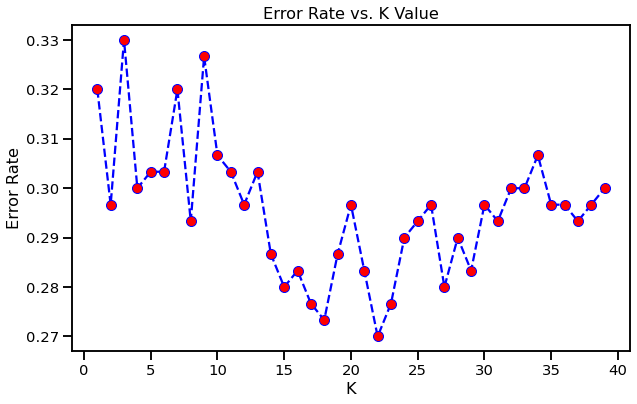

Minimum error:- 0.27 at K = 22


In [34]:
error_rate = []
for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 #print (pred_i)
 #print (1-accuracy_score(y_test, pred_i))
 error_rate.append(1-accuracy_score(y_test, pred_i))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)

In [35]:
knn = KNeighborsClassifier(n_neighbors=22, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=22)

In [36]:
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.73